# Text Classification Using RNN
This tutorial shows how to classify text using a recurrent neural network (RNN) on the IMDB large movie review dataset for sentiment analysis. 

In [25]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout

import matplotlib.pyplot as plt

In [2]:
# matplotlib helper function
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

## Set Up Input Pipeline
The IMDB large movie review dataset is a binary classification dataset. All the reviews have either a positive or negative sentiment.

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

The dataset `info` includes the [encoder](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder).

In [4]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabularys size: {}'.format(encoder.vocab_size))

Vocabularys size: 8185


The text encoder will reversibly encode any string, falling back to byte-encoding if necessary. 

In [9]:
sample_string = "You are tearing me apart, Lisa!"

encoded_string = encoder.encode(sample_string)
print('Encoded string is: {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string is: {}'.format(original_string))

Encoded string is: [298, 29, 3857, 34, 105, 3867, 2, 3943, 8026, 7962]
The original string is: You are tearing me apart, Lisa!


In [10]:
assert original_string == sample_string

In [11]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

298 ----> You 
29 ----> are 
3857 ----> tear
34 ----> ing 
105 ----> me 
3867 ----> apart
2 ----> , 
3943 ----> Lis
8026 ----> a
7962 ----> !


### Prepare Data for Training
Create batches of the encoded strings. Use the `padded_batch` method to zero-pad the sequences of the length of the longest string in the batch. 

In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, train_dataset.output_shapes)

test_dataset = test_dataset.padded_batch(BATCH_SIZE, test_dataset.output_shapes)

## Build the Model
Build a `tf.keras.Sequential` model and start with an embedding layer. An embedding layer stores one vector per word. When called, it convets the sequences of word indices to sequences of vectors. These vectors are trainable. After training on enough data, words with similar meanings will often have similar vectors.

This index-lookup is much more efficient thatn the equivalent operation of passing a one-hot encoded vector through `tf.keras.layers.Dense`. 

The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and concatenates the output. This helps the RNN to learn long range dependencies. 

In [17]:
model = Sequential([
    Embedding(encoder.vocab_size, 64), 
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'), 
    Dense(1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## Train the Model

In [20]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 626s 2s/step - loss: 0.5345 - accuracy: 0.7229 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
391/391 [==============================] - 593s 2s/step - loss: 0.3676 - accuracy: 0.8514 - val_loss: 0.3824 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 647s 2s/step - loss: 0.2873 - accuracy: 0.8894 - val_loss: 0.4178 - val_accuracy: 0.8208
Epoch 4/10
391/391 [==============================] - 642s 2s/step - loss: 0.2325 - accuracy: 0.9139 - val_loss: 0.4322 - val_accuracy: 0.8260
Epoch 5/10
391/391 [==============================] - 599s 2s/step - loss: 0.3095 - accuracy: 0.8727 - val_loss: 0.4273 - val_accuracy: 0.8307
Epoch 6/10
391/391 [==============================] - 519s 1s/step - loss: 0.1819 - accuracy: 0.9346 - val_loss: 0.4624 - val_accuracy: 0.8370
Epoch 7/10
391/391 [==============================] - 515s 1s/step - loss: 0.1401 - accuracy: 0.9526 - val_loss: 0.5123 - val_accuracy

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test loss: {}'.format(test_loss))
print('Test accuracy: {}'.format(test_acc))

391/391 [==============================] - 126s 324ms/step - loss: 0.6472 - accuracy: 0.7841
Test loss: 0.647202057225625
Test accuracy: 0.7840800285339355


The above model does not mask the padding applied to the sequences. This can skew the results if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but this has a small effect on our dataset.

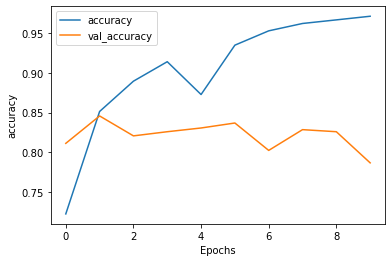

In [22]:
# plot results
plot_graphs(history, 'accuracy')

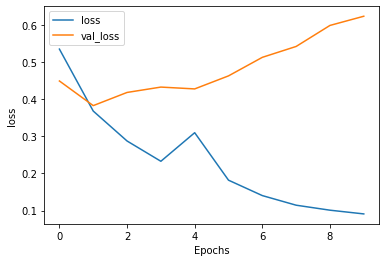

In [23]:
plot_graphs(history, 'loss')

## Stack Two or More LTSM Layers
Keras recurrent layers have two available models that are controlled by the `return_sequences` constructor argument:
- Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`). 
- Return only the last output for each input sequence (a 2D tensor shape of `(batch_size, output_features)`).

In [26]:
model = Sequential([
    Embedding(encoder.vocab_size, 64),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)), 
    Dense(64, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 635,329
Trainable params: 635,329
Non-trainable params: 0
________________________________________________

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
     56/Unknown - 141s 3s/step - loss: 0.6926 - accuracy: 0.5140